In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# evaluate linear algorithms
from numpy import load
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from sklearn.base import clone
from scipy.stats import sem
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
#import shap
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import MinMaxScaler

import os
import pandas as pd
import glob
import math
import datetime
import time
import numpy as np
import scipy
import random

random.seed(10)

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [9]:
def convert_to_preferred_format(sec):
    sec = sec % (24 * 3600)
    hour = sec // 3600
    sec %= 3600
    min = sec // 60
    sec %= 60
#  print("seconds value in hours:",hour)
#  print("seconds value in minutes:",min)

#return "%02d:%02d:%02d" % (hour, min, sec)
    return "%02d:%02d" % (hour, min)

In [10]:
merged_data = '/content/drive/MyDrive/NHANCE data analysis/NonNormalizedMergedData10min'
merged_files = os.listdir(merged_data)

In [11]:
all_data = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.03855e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


-------------------------------------
Ridge Regression
MAE and STD error for Perception Labels
[0.21055084 0.21138919 0.21164771]
[0.00985804 0.00967364 0.0095665 ]
-------------------------------------
-------------------------------------
Support Vector Regression
MAE and STD error for Perception Labels
[0.22042553 0.22085106 0.2212766 ]
[0.00955502 0.00940785 0.00943263]
-------------------------------------
-------------------------------------
Gradient Boosting Regression
MAE and STD error for Perception Labels
[0.13268705 0.13854113 0.13946018]
[0.00761119 0.00778673 0.00742896]
-------------------------------------
-------------------------------------
Random Forest Regression
MAE and STD error for Perception Labels
[0.12148936 0.1267234  0.12523404]
[0.00782236 0.00744593 0.00795285]
-------------------------------------


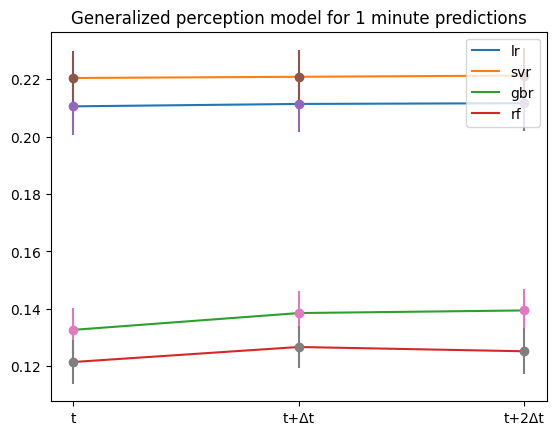

In [12]:
#@title Default title text
n_timesteps_in = 3
n_timesteps_out = 3

#parent_X = np.empty((1, n_timesteps_in, 26))
parent_X = np.empty((1, n_timesteps_in,26))
parent_y = np.empty((1, 3))

for el in merged_files:
  os.chdir(merged_data)
  data = pd.read_csv(el)
  data.drop(['Unnamed: 0','time_stamp','Performance'], axis = 1, inplace = True)
  data['Times'] =  pd.to_datetime(data['Times'])
  data = data.set_index(['Times'])
  data_1 = data.resample('1min').mean()
  cols = list(data_1.columns)
  cols = cols[1:]
  data_1 = data_1[cols]
  #all_data = all_data.append(data_1)
  X, y = split_sequences(data_1.values, n_timesteps_in, n_timesteps_out)
  parent_X = np.vstack((parent_X, X))

  parent_y = np.vstack((parent_y, y))


#sampling at 1 minute. Hence predicting, 1, 2 and 3 minutes into future
all_err_lr_1 = []
all_err_svr_1 = []
all_err_gbr_1 = []
all_err_rf_1 = []


# convert dataset into input/output
#X, y = split_sequences(all_data.values, n_timesteps_in, n_timesteps_out)
X_train, X_test, y_train, y_test = train_test_split(parent_X, parent_y, test_size=0.2, shuffle= True)

# convert 3D array into 2D
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

model_linreg = Ridge()
model_linreg.fit(X_train, y_train)
y_predict_lr = model_linreg.predict(X_test)

abs_err_lr = abs(y_predict_lr - y_test)
#all_err_lr_1.append(abs_err_lr.mean(axis = 0))

model_svr = MultiOutputRegressor(SVR())
model_svr.fit(X_train, y_train)
y_predict_svr = model_svr.predict(X_test)

abs_err_svr = abs(y_predict_svr - y_test)
#all_err_svr_1.append(abs_err_svr.mean(axis = 0))

model_gbr = MultiOutputRegressor(GradientBoostingRegressor())
model_gbr.fit(X_train, y_train)
y_predict_gbr = model_gbr.predict(X_test)

abs_err_gbr = abs(y_predict_gbr - y_test)
#all_err_gbr_1.append(abs_err_gbr.mean(axis = 0))


model_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10))
model_rf.fit(X_train, y_train)
y_predict_rf = model_rf.predict(X_test)

abs_err_rf = abs(y_predict_rf - y_test)
#all_err_rf_1.append(abs_err_rf.mean(axis = 0))


#error_values_lr = np.asarray(all_err_lr_1)
#error_values_lr = np.asarray(abs_err_lr.mean(axis=0))
error_values_lr = np.asarray(abs_err_lr)
mean_error_lr = error_values_lr.mean(axis = 0)
#std_error_lr = 1/np.sqrt(31)*error_values_lr.std(axis = 0)
std_error_lr = scipy.stats.sem(error_values_lr, axis=0, ddof=0, nan_policy='omit')

print('-------------------------------------')
print('Ridge Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_lr)
print(std_error_lr)
print('-------------------------------------')

#error_values_svr = np.asarray(all_err_svr_1)
#error_values_svr = np.asarray(abs_err_lr.mean(axis=0))
error_values_svr = np.asarray(abs_err_svr)
mean_error_svr = error_values_svr.mean(axis = 0)
#std_error_svr = 1/np.sqrt(31)*error_values_svr.std(axis = 0)
std_error_svr = scipy.stats.sem(error_values_svr, axis=0, ddof=0, nan_policy='omit')

print('-------------------------------------')
print('Support Vector Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_svr)
print(std_error_svr)
print('-------------------------------------')

#error_values_gbr = np.asarray(all_err_gbr_1)
#error_values_gbr = np.asarray(abs_err_gbr.mean(axis=0))
error_values_gbr = np.asarray(abs_err_gbr)
mean_error_gbr = error_values_gbr.mean(axis = 0)
#std_error_gbr = 1/np.sqrt(31)*error_values_gbr.std(axis = 0)
std_error_gbr = scipy.stats.sem(error_values_gbr, axis=0, ddof=0, nan_policy='omit')

print('-------------------------------------')
print('Gradient Boosting Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_gbr)
print(std_error_gbr)
print('-------------------------------------')


#error_values_rf = np.asarray(all_err_rf_1)
#error_values_rf = np.asarray(abs_err_rf.mean(axis=0))
error_values_rf = np.asarray(abs_err_rf)
mean_error_rf = error_values_rf.mean(axis = 0)
#std_error_rf = 1/np.sqrt(31)*error_values_rf.std(axis = 0)
std_error_rf = scipy.stats.sem(error_values_rf, axis=0, ddof=0, nan_policy='omit')

print('-------------------------------------')
print('Random Forest Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_rf)
print(std_error_rf)
print('-------------------------------------')

perf = pd.DataFrame(np.stack((mean_error_lr, mean_error_svr, mean_error_gbr, mean_error_rf), axis = 0))
perf_std_ = pd.DataFrame(np.stack((std_error_lr, std_error_svr, std_error_gbr, std_error_rf), axis = 0))

x_lr = perf.iloc[0]
x_svr = perf.iloc[1]
x_gbr = perf.iloc[2]
x_rf = perf.iloc[3]
actual_x = ['t','t+Δt','t+2Δt']
plt.title("Generalized perception model for 1 minute predictions")
plt.plot(actual_x, x_lr, label = "lr")
plt.plot(actual_x, x_svr, label = "svr")
plt.plot(actual_x, x_gbr, label = "gbr")
plt.plot(actual_x, x_rf, label = "rf")

plt.errorbar(actual_x, x_lr, yerr = perf_std_.iloc[0], fmt = 'o')
plt.errorbar(actual_x, x_svr, yerr = perf_std_.iloc[1], fmt = 'o')
plt.errorbar(actual_x, x_gbr, yerr = perf_std_.iloc[2], fmt = 'o')
plt.errorbar(actual_x, x_rf, yerr = perf_std_.iloc[3], fmt = 'o')

plt.legend(loc="upper right")
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


-------------------------------------
Ridge Regression
MAE and STD error for Perception Labels
[0.12999751 0.09231178 0.19564533]
[0.06433071 0.02931957 0.06348309]
-------------------------------------
-------------------------------------
Support Vector Regression
MAE and STD error for Perception Labels
[0.05684244 0.07169104 0.05866741]
[0.01322186 0.02689698 0.0234379 ]
-------------------------------------
-------------------------------------
Gradient Boosting Regression
MAE and STD error for Perception Labels
[0.07777343 0.08056248 0.10801386]
[0.0166467  0.01922631 0.02076149]
-------------------------------------
-------------------------------------
Random Forest Regression
MAE and STD error for Perception Labels
[0.05919072 0.06509129 0.0762962 ]
[0.0245929  0.02397673 0.0222642 ]
-------------------------------------


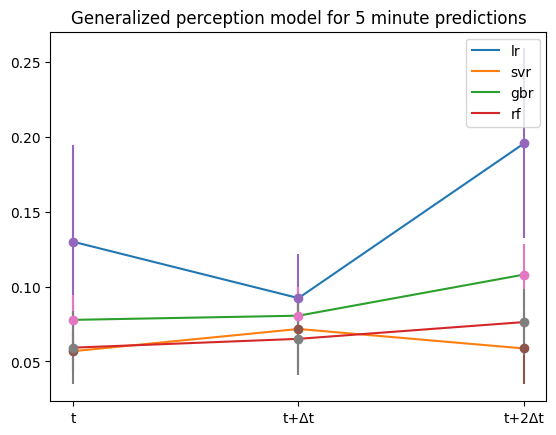

In [ ]:
#@title Default title text
#sampling at 5 minutes. Hence predicting 5, 10 and 15 minutes into future

all_err_lr_2 = []
all_err_svr_2 = []
all_err_gbr_2 = []
all_err_rf_2 = []

parent_X = np.empty((1, n_timesteps_in,26))
parent_y = np.empty((1, 3))

for el in merged_files:
  os.chdir(merged_data)
  data = pd.read_csv(el)
  data.drop(['Unnamed: 0','time_stamp','Performance'], axis = 1, inplace = True)
  data['Times'] =  pd.to_datetime(data['Times'])
  data = data.set_index(['Times'])
  data_1 = data.resample('5min').mean()
  cols = list(data_1.columns)
  cols = cols[1:]
  #cols.append('response_correctness')
  data_1 = data_1[cols]

  n_timesteps_in = 3
  n_timesteps_out = 3

  # convert dataset into input/output
  X, y = split_sequences(data_1.values, n_timesteps_in, n_timesteps_out)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)

  # convert 3D array into 2D
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

  model_linreg = Ridge()
  model_linreg.fit(X_train, y_train)
  y_predict_lr_2 = model_linreg.predict(X_test)

  abs_err_lr_2 = abs(y_predict_lr_2 - y_test)
  #all_err_lr_2.append(abs_err_lr.mean(axis = 0))

  model_svr = MultiOutputRegressor(SVR())
  model_svr.fit(X_train, y_train)
  y_predict_svr_2 = model_svr.predict(X_test)

  abs_err_svr_2 = abs(y_predict_svr_2 - y_test)
  #all_err_svr_2.append(abs_err_svr.mean(axis = 0))

  model_gbr = MultiOutputRegressor(GradientBoostingRegressor())
  model_gbr.fit(X_train, y_train)
  y_predict_gbr_2 = model_gbr.predict(X_test)

  abs_err_gbr_2 = abs(y_predict_gbr_2 - y_test)
  #all_err_gbr_2.append(abs_err_gbr.mean(axis = 0))

  model_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10))
  model_rf.fit(X_train, y_train)
  y_predict_rf_2 = model_rf.predict(X_test)

  abs_err_rf_2 = abs(y_predict_rf_2 - y_test)
  #all_err_rf_2.append(abs_err_rf.mean(axis = 0))


error_values_lr_2 = np.asarray(abs_err_lr_2)
mean_error_lr_2 = error_values_lr_2.mean(axis = 0)
#std_error_lr_2 = 1/np.sqrt(31)*error_values_lr_2.std(axis = 0)
std_error_lr_2 = scipy.stats.sem(error_values_lr_2 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Ridge Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_lr_2)
print(std_error_lr_2)
print('-------------------------------------')

error_values_svr_2 = np.asarray(abs_err_svr_2)
mean_error_svr_2 = error_values_svr_2.mean(axis = 0)
#std_error_svr_2 = 1/np.sqrt(31)*error_values_svr_2.std(axis = 0)
std_error_svr_2 = scipy.stats.sem(error_values_svr_2 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Support Vector Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_svr_2)
print(std_error_svr_2)
print('-------------------------------------')

error_values_gbr_2 = np.asarray(abs_err_gbr_2)
mean_error_gbr_2 = error_values_gbr_2.mean(axis = 0)
#std_error_gbr_2 = 1/np.sqrt(31)*error_values_gbr_2.std(axis = 0)
std_error_gbr_2 = scipy.stats.sem(error_values_gbr_2 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Gradient Boosting Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_gbr_2)
print(std_error_gbr_2)
print('-------------------------------------')


error_values_rf_2 = np.asarray(abs_err_rf_2)
mean_error_rf_2 = error_values_rf_2.mean(axis = 0)
#std_error_rf_2 = 1/np.sqrt(31)*error_values_rf_2.std(axis = 0)
std_error_rf_2 = scipy.stats.sem(error_values_rf_2 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Random Forest Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_rf_2)
print(std_error_rf_2)
print('-------------------------------------')

perf_2 = pd.DataFrame(np.stack((mean_error_lr_2, mean_error_svr_2, mean_error_gbr_2, mean_error_rf_2), axis = 0))
perf_std_2 = pd.DataFrame(np.stack((std_error_lr_2, std_error_svr_2, std_error_gbr_2, std_error_rf_2), axis = 0))


x_lr_2 = perf_2.iloc[0]
x_svr_2 = perf_2.iloc[1]
x_gbr_2 = perf_2.iloc[2]
x_rf_2 = perf_2.iloc[3]
plt.title("Generalized perception model for 5 minute predictions")
actual_x = ['t','t+Δt','t+2Δt']
plt.plot(actual_x, x_lr_2, label = "lr")
plt.plot(actual_x, x_svr_2, label = "svr")
plt.plot(actual_x, x_gbr_2, label = "gbr")
plt.plot(actual_x, x_rf_2, label = "rf")

plt.errorbar(actual_x, x_lr_2, yerr = perf_std_2.iloc[0], fmt = 'o')
plt.errorbar(actual_x, x_svr_2, yerr = perf_std_2.iloc[1], fmt = 'o')
plt.errorbar(actual_x, x_gbr_2, yerr = perf_std_2.iloc[2], fmt = 'o')
plt.errorbar(actual_x, x_rf_2, yerr = perf_std_2.iloc[3], fmt = 'o')

plt.legend(loc="upper right")
plt.show()


<ipython-input-8-45c8e4a367f5>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(data_1)
<ipython-input-8-45c8e4a367f5>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(data_1)
<ipython-input-8-45c8e4a367f5>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(data_1)
<ipython-input-8-45c8e4a367f5>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(data_1)
<ipython-input-8-45c8e4a367f5>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data =

-------------------------------------
Ridge Regression
MAE and STD error for Perception Labels
[1.04534065e+12 6.31323065e+11 2.32724817e+12]
[1.02504084e+12 6.19063197e+11 2.28205458e+12]
-------------------------------------
-------------------------------------
Support Vector Regression
MAE and STD error for Perception Labels
[0.23914125 0.229194   0.23985507]
[0.03203772 0.031595   0.0317699 ]
-------------------------------------
-------------------------------------
Gradient Boosting Regression
MAE and STD error for Perception Labels
[0.2065618  0.21899745 0.22216898]
[0.02949206 0.03099711 0.03351484]
-------------------------------------
-------------------------------------
Random Forest Regression
MAE and STD error for Perception Labels
[0.20844143 0.18821433 0.21805505]
[0.02491604 0.02388417 0.03263117]
-------------------------------------


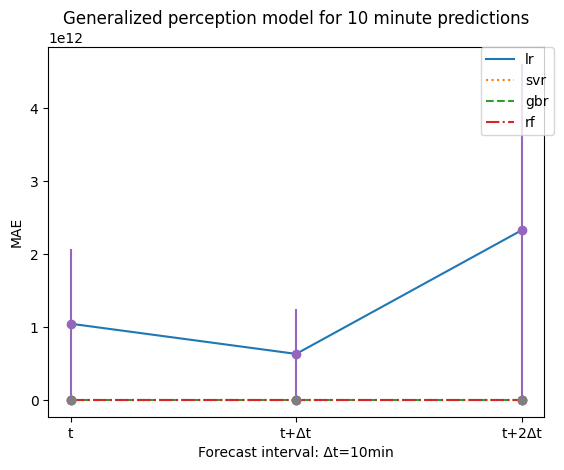

In [ ]:
#sampling at 10 minutes. Hence predicting, 10, 20 and 30 minutes into future
random.seed(10)

n_timesteps_in = 3
n_timesteps_out = 3
all_err_lr_3 = []
all_err_svr_3 = []
all_err_gbr_3 = []
all_err_rf_3 = []

all_data = pd.DataFrame()
parent_X = np.empty((1, n_timesteps_in,26))
parent_y = np.empty((1, 3))

for el in merged_files:
  os.chdir(merged_data)
  data = pd.read_csv(el)
  data.drop(['Unnamed: 0','time_stamp','Performance'], axis = 1, inplace = True)
  data['Times'] =  pd.to_datetime(data['Times'])
  data = data.set_index(['Times'])
  data_1 = data.resample('10min').mean()
  cols = list(data_1.columns)
  cols = cols[1:]
  data_1 = data_1[cols]
  all_data = all_data.append(data_1)



# convert dataset into input/output
X, y = split_sequences(all_data.values, n_timesteps_in, n_timesteps_out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)

# convert 3D array into 2D
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

model_linreg = Ridge()
model_linreg.fit(X_train, y_train)
y_predict_lr_3 = model_linreg.predict(X_test)

abs_err_lr_3 = abs(y_predict_lr_3 - y_test)
#all_err_lr_3.append(abs_err_lr.mean(axis = 0))

model_svr = MultiOutputRegressor(SVR())
model_svr.fit(X_train, y_train)
y_predict_svr_3 = model_svr.predict(X_test)

abs_err_svr_3 = abs(y_predict_svr_3 - y_test)
#all_err_svr_3.append(abs_err_svr.mean(axis = 0))

model_gbr = MultiOutputRegressor(GradientBoostingRegressor())
model_gbr.fit(X_train, y_train)
y_predict_gbr_3 = model_gbr.predict(X_test)

abs_err_gbr_3 = abs(y_predict_gbr_3 - y_test)
#all_err_gbr_3.append(abs_err_gbr.mean(axis = 0))

model_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10))
model_rf.fit(X_train, y_train)
y_predict_rf_3 = model_rf.predict(X_test)

abs_err_rf_3 = abs(y_predict_rf_3 - y_test)
#all_err_rf_3.append(abs_err_rf.mean(axis = 0))


error_values_lr_3 = np.asarray(abs_err_lr_3)
mean_error_lr_3 = error_values_lr_3.mean(axis = 0)
#std_error_lr_3 = 1/np.sqrt(31)*error_values_lr_3.std(axis = 0)
std_error_lr_3 = scipy.stats.sem(error_values_lr_3 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Ridge Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_lr_3)
print(std_error_lr_3)
print('-------------------------------------')

error_values_svr_3 = np.asarray(abs_err_svr_3)
mean_error_svr_3 = error_values_svr_3.mean(axis = 0)
#std_error_svr_3 = 1/np.sqrt(31)*error_values_svr_3.std(axis = 0)
std_error_svr_3 = scipy.stats.sem(error_values_svr_3 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Support Vector Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_svr_3)
print(std_error_svr_3)
print('-------------------------------------')

error_values_gbr_3 = np.asarray(abs_err_gbr_3)
mean_error_gbr_3 = error_values_gbr_3.mean(axis = 0)
#std_error_gbr_3 = 1/np.sqrt(31)*error_values_gbr_3.std(axis = 0)
std_error_gbr_3 = scipy.stats.sem(error_values_gbr_3 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Gradient Boosting Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_gbr_3)
print(std_error_gbr_3)
print('-------------------------------------')


error_values_rf_3 = np.asarray(abs_err_rf_3)
mean_error_rf_3 = error_values_rf_3.mean(axis = 0)
#std_error_rf_3 = 1/np.sqrt(31)*error_values_rf_3.std(axis = 0)
std_error_rf_3 = scipy.stats.sem(error_values_rf_3 , axis=0, ddof=0, nan_policy='propagate')

print('-------------------------------------')
print('Random Forest Regression')
print('MAE and STD error for Perception Labels')
print(mean_error_rf_3)
print(std_error_rf_3)
print('-------------------------------------')

perf_3 = pd.DataFrame(np.stack((mean_error_lr_3, mean_error_svr_3, mean_error_gbr_3, mean_error_rf_3), axis = 0))
perf_std_3 = pd.DataFrame(np.stack((std_error_lr_3, std_error_svr_3, std_error_gbr_3, std_error_rf_3), axis = 0))


x_lr_3 = perf_3.iloc[0]
x_svr_3 = perf_3.iloc[1]
x_gbr_3 = perf_3.iloc[2]
x_rf_3 = perf_3.iloc[3]
actual_x = ['t','t+Δt','t+2Δt']
plt.title("Generalized perception model for 10 minute predictions")
plt.ylabel("Mean absolute error")
plt.plot(actual_x, x_lr_3, label = "lr", linestyle = 'solid')
plt.plot(actual_x, x_svr_3, label = "svr", linestyle = 'dotted')
plt.plot(actual_x, x_gbr_3, label = "gbr", linestyle = 'dashed')
plt.plot(actual_x, x_rf_3, label = "rf", linestyle = 'dashdot')

plt.errorbar(actual_x, x_lr_3, yerr = perf_std_3.iloc[0], fmt = 'o')
plt.errorbar(actual_x, x_svr_3, yerr = perf_std_3.iloc[1], fmt = 'o')
plt.errorbar(actual_x, x_gbr_3, yerr = perf_std_3.iloc[2], fmt = 'o')
plt.errorbar(actual_x, x_rf_3, yerr = perf_std_3.iloc[3], fmt = 'o')

#plt.legend(loc="bottom")
plt.ylabel("MAE")
plt.xlabel("Forecast interval: Δt=10min")
plt.legend(bbox_to_anchor=(1.02, 1), loc='best', borderaxespad=0)
plt.show()

In [ ]:
model_linreg.get_params


<bound method BaseEstimator.get_params of Ridge()>

In [ ]:
feature_importance = model_gbr.feature_importances_

AttributeError: ignored

In [ ]:
random.seed(10)
X1 = all_data[['sdnn', 'sdsd', 'nni_50', 'pnni_50',
       'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd',
       'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'lf', 'hf',
       'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf', 'sd1', 'sd2',
       'ratio_sd2_sd1', 'sampen']]

#X values are missing mean_nni
y1 = all_data['Fatigue Perception']
#all_data1 = all_data.dropna(inplace = True)
#X1 = pd.DataFrame(all_data1.loc[:,0:25], columns = cols)
#y1 = pd.DataFrame(all_data1.loc[:,-1:])

X_train, X_test, y_train, y_test = train_test_split(X1,y1 ,random_state=104, test_size=0.20, shuffle=False)
regressor = RandomForestRegressor(n_estimators=10, random_state = 0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
#mae_ = sum(abs(y_pred-y_test))/len(y_test)
mae_ = abs(y_pred-y_test)


In [ ]:
regressor_gbr = GradientBoostingRegressor()
regressor_gbr.fit(X_train, y_train)
y_pred_gbr = regressor_gbr.predict(X_test)
mae_gbr = abs(y_pred_gbr - y_test)

mean_error_mae_gbr = np.array(mae_gbr).mean(axis = 0)
std_error_mae_gbr = scipy.stats.sem(np.array(mae_gbr), axis = 0, ddof=0,nan_policy='propagate')
print("MAE is ",mean_error_mae_gbr," and the standard error is +/- ",std_error_mae_gbr)

MAE is  0.2492214048776083  and the standard error is +/-  0.030651970599553907


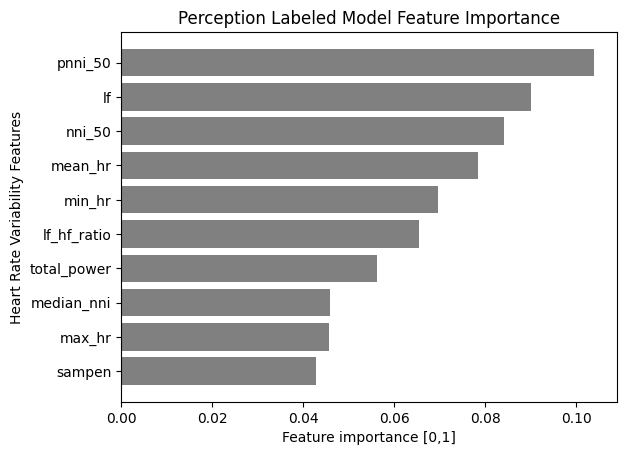

In [ ]:
regressor_gbr.feature_importances_
sorted_idx = regressor_gbr.feature_importances_.argsort()
sorted_idx = sorted_idx[16:26]
c = 'grey'
plt.barh(X1.columns[sorted_idx], regressor_gbr.feature_importances_[sorted_idx], color = c)
plt.ylabel("Heart Rate Variability Features")
plt.xlabel("Feature importance [0,1]")
plt.title("Perception Labeled Model Feature Importance")
plt.savefig('perceptionfeatureimportance.png', format = 'png', dpi=1200)
plt.show()

In [ ]:
# error_values_rf_3 = np.asarray(abs_err_rf_3)
# mean_error_rf_3 = error_values_rf_3.mean(axis = 0)
# #std_error_rf_3 = 1/np.sqrt(31)*error_values_rf_3.std(axis = 0)
# std_error_rf_3 = scipy.stats.sem(error_values_rf_3 , axis=0, ddof=0, nan_policy='propagate')

mean_error_mae = np.array(mae_).mean(axis = 0)
std_error_mae = scipy.stats.sem(np.array(mae_), axis = 0, ddof=0,nan_policy='propagate')
print("MAE is ",mean_error_mae," and the standard error is +/- ",std_error_mae)

MAE is  0.2324590674008831  and the standard error is +/-  0.02576765689032851


Text(0.5, 1.0, 'Feature Importance of HRV Features in Perception Scores Prediction')

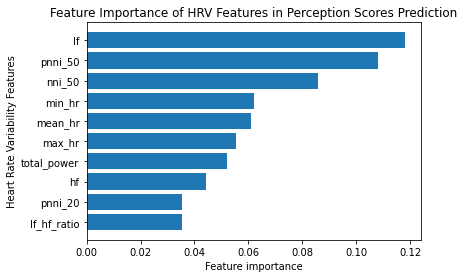

In [ ]:
regressor.feature_importances_
sorted_idx = regressor.feature_importances_.argsort()
sorted_idx = sorted_idx[16:26]
plt.barh(X1.columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.ylabel("Heart Rate Variability Features")
plt.xlabel("Feature importance")
plt.title("Feature Importance of HRV Features in Perception Scores Prediction")

In [ ]:
len(model_rf.estimators_)

3

In [ ]:
#model_rf.estimators_[0].feature_importances_

regr_Enet = ElasticNet()
regr_multi_Enet= MultiOutputRegressor(regr_Enet)
regr_multi_Enet.fit(X_train, y_train.values.reshape(-1,1))

regr_multi_Enet.estimators_[0].coef_
# array([ 0.08333333,  0.        ])

#regr_multi_Enet.estimators_[1].coef_
# array([ 0.08333333,  0.        ])

array([ 0.00000000e+00, -0.00000000e+00,  2.63606826e-03,  0.00000000e+00,
       -5.59783178e-05, -0.00000000e+00, -0.00000000e+00, -2.83421267e-04,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.78155950e-04,  0.00000000e+00,  0.00000000e+00,  1.34036375e-04,
        5.79247341e-05,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -4.23973603e-06, -2.54649989e-05, -0.00000000e+00,  1.79560441e-03,
        6.00356054e-16, -0.00000000e+00])

Text(0.5, 1.0, 'RF generalized perception feature importance')

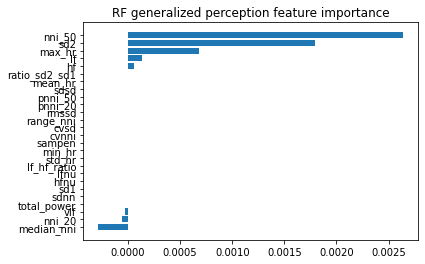

In [ ]:
#len(model_rf.estimators_[0].feature_importances_)
# plt.barh(X_test.columns, model_rf.estimators_[0].feature_importances_)
sorted_idx_1 = regr_multi_Enet.estimators_[0].coef_.argsort()
sorted_idx_1 = sorted_idx_1#[21:26]
#plt.barh(X1.columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.barh(X_test.columns[sorted_idx_1], regr_multi_Enet.estimators_[0].coef_[sorted_idx_1])
plt.title("RF generalized perception feature importance")